In [1]:
import os
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basedir = "/home/pcktm/inzynierka/kitti/dataset"

In [27]:
test_dataset = KittiGraphDataset(basedir, "09", graph_length=7)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [32]:
checkpoint = torch.load("./models/model_B_90.pth")

model = PoseGNN()
model.load_state_dict(checkpoint)
model.to(device)

PoseGNN(
  (conv1): GraphConv(2048, 256)
  (conv2): GraphConv(256, 128)
  (conv3): GraphConv(128, 64)
  (position): Linear(in_features=64, out_features=3, bias=True)
  (orientation): Linear(in_features=64, out_features=4, bias=True)
)

In [33]:
def odometry_predicted_poses(predictions):
  """
  predictions: list of predictions

  This function adds the predictions of shifts to the previous position and rotation, 
  returing the absolute position and rotation.
  """
  world_positions = []
  world_rotations = []

  for i, prediction in enumerate(predictions):
    if i == 0:
      world_positions.append(prediction["position"])
      world_rotations.append(prediction["rotation"])
    else:
      world_positions.append(world_positions[i-1] + prediction["position"])
      # now, rotations are in quaternion form so use appropriate function
      world_rotations.append(world_rotations[i-1] * prediction["rotation"])

  # return [{"position": pos, "rotation": rot} for pos, rot in zip(world_positions, world_rotations)]
  return [
    {
      "position": pos,
      "rotation": rot.as_quat(),
    }
    for pos, rot in zip(world_positions, world_rotations)
  ]

In [19]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    rot = tensor[3:]

    rot = R.from_quat(rot)
    return {
        "position": pos,
        "rotation": rot,
    }

In [34]:
SELECTED_IDX = 6

predicted_poses = []
true_poses = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch)
        predicted_poses.append(output.cpu().numpy()[SELECTED_IDX])
        true_poses.append(batch.y.cpu().numpy()[SELECTED_IDX])

100%|██████████| 1584/1584 [00:04<00:00, 391.59it/s]


Predicted poses:
[{'position': array([0.42287925, 0.08779507, 0.09315217], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fec2be62d30>}, {'position': array([0.42508075, 0.08775144, 0.09116907], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fec2be62e20>}, {'position': array([0.4251856 , 0.07568722, 0.09625239], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fec2be62790>}, {'position': array([0.4253027 , 0.08365195, 0.09398688], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fec2be62f10>}, {'position': array([0.42909333, 0.07698935, 0.09728981], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fec2be63000>}, {'position': array([0.43678764, 0.07764714, 0.09968991], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fec2be62880>}, {'position': array([0.4307311 , 0.080117

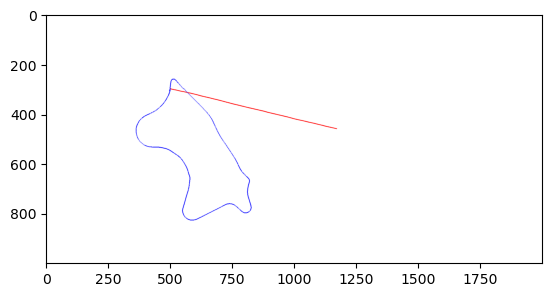

In [37]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

print("Predicted poses:")
print(predicted_poses_e)

trajectory_image = np.zeros((1000, 2000, 3), dtype=np.uint8)
trajectory_image.fill(255)

predicted_world_poses = odometry_predicted_poses(predicted_poses_e)

for i in range(len(predicted_world_poses)):
    pos = predicted_world_poses[i]["position"]
    x = int(pos[0]) + 500
    y = int(pos[2]) + 300

    gt_x = int(true_poses_e[i]["position"][0]) + 500
    gt_y = int(true_poses_e[i]["position"][2]) + 300

    cv2.circle(trajectory_image, (x, y), 1, (0, 0, 255), 1)
    cv2.circle(trajectory_image, (gt_x, gt_y), 1, (255, 0, 0), 1)

trajectory_image = cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB)
plt.imshow(trajectory_image)